# NLP Fake News Detection
# Benjamin Chumaceiro and Max Franco

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from spacy.lang.en import English
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from nltk.stem import WordNetLemmatizer 
import numpy as np

In [ ]:
nlp = spacy.load('en_core_web_sm')

In [ ]:
#Import Data
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/NLP/fake_or_real_news_training.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/NLP/fake_or_real_news_test.csv")

In [ ]:
#checking columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3999 entries, 0 to 3998
Data columns (total 6 columns):
ID       3999 non-null int64
title    3999 non-null object
text     3999 non-null object
label    3999 non-null object
X1       33 non-null object
X2       2 non-null object
dtypes: int64(1), object(5)
memory usage: 187.6+ KB


In [ ]:
#checking columns
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2321 entries, 0 to 2320
Data columns (total 3 columns):
ID       2321 non-null int64
title    2321 non-null object
text     2321 non-null object
dtypes: int64(1), object(2)
memory usage: 54.5+ KB


# Cleaning Train set

We checked why we have the 2 extra columns in train set

In [ ]:
train[(pd.notnull(train['X1'])) | (pd.notnull(train['X2']))].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33 entries, 192 to 3706
Data columns (total 6 columns):
ID       33 non-null int64
title    33 non-null object
text     33 non-null object
label    33 non-null object
X1       33 non-null object
X2       2 non-null object
dtypes: int64(1), object(5)
memory usage: 1.8+ KB


Since there are only 33 rows which have this issue, we decided to drop them
 

In [ ]:
#drop rows with issues
train = train.drop(train[(train["label"] != "REAL") & (train["label"] != "FAKE")].index)
#drop columns X1 & X2
train = train.drop(columns=["X1","X2"])


In [ ]:
#Concatenate Datasets in order to do feature engineering
df = pd.concat([train, test])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


## Exploration Data Analysis

(array([  7.,  21.,  47., 120., 199., 238., 287., 276., 268., 207., 142.,
         76.,  38.,  35.,   8.,  10.,   7.,   1.,   2.,   1.]),
 array([ 10. ,  16.9,  23.8,  30.7,  37.6,  44.5,  51.4,  58.3,  65.2,
         72.1,  79. ,  85.9,  92.8,  99.7, 106.6, 113.5, 120.4, 127.3,
        134.2, 141.1, 148. ]),
 <a list of 20 Patch objects>)

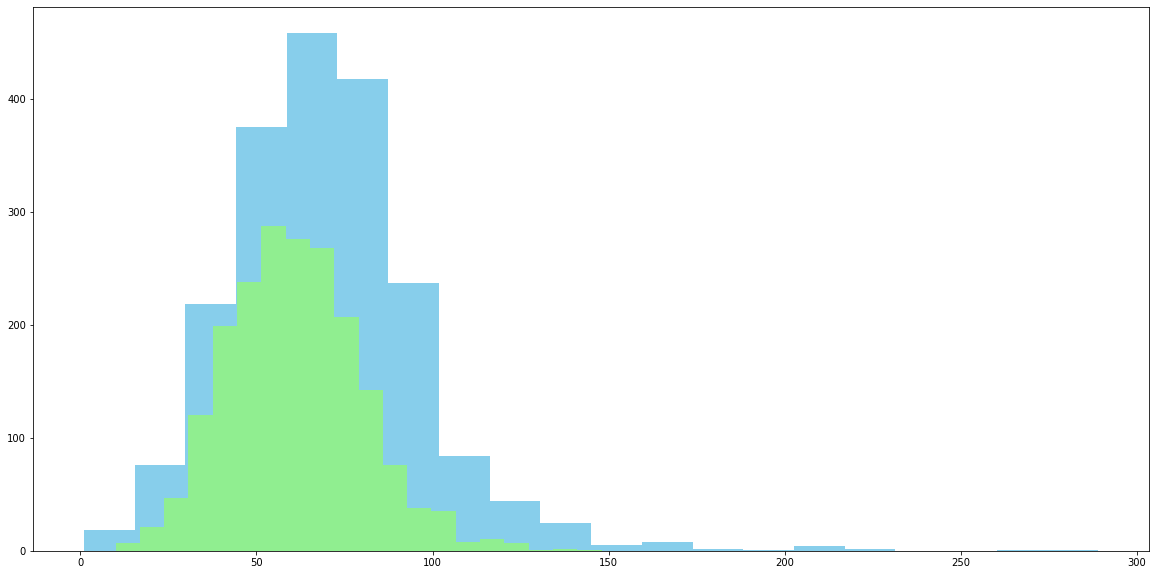

In [17]:
# Explorating and analysing title lenght
train["title_len"] = train["title"].apply(lambda x: len(x))
plt.figure(figsize=(20,10))
plt.hist(train.loc[train.label=="FAKE",:]["title_len"],bins=20,color = "skyblue")
plt.hist(train.loc[train.label=="REAL",:]["title_len"],bins=20, color = "LightGreen")

We can detect the diference of lenght between the fake and Real titles of News

In [18]:
(train.loc[train.label=="FAKE",:]["title_len"]).describe()

count    1976.000000
mean       69.628036
std        27.490183
min         1.000000
25%        52.000000
50%        68.000000
75%        84.000000
max       289.000000
Name: title_len, dtype: float64

In [23]:
(train.loc[train.label=="REAL",:]["title_len"]).describe()

count    1990.000000
mean       61.088442
std        18.946545
min        10.000000
25%        48.000000
50%        60.000000
75%        73.000000
max       148.000000
Name: title_len, dtype: float64

(array([  7.,  21.,  47., 120., 199., 238., 287., 276., 268., 207., 142.,
         76.,  38.,  35.,   8.,  10.,   7.,   1.,   2.,   1.]),
 array([ 10. ,  16.9,  23.8,  30.7,  37.6,  44.5,  51.4,  58.3,  65.2,
         72.1,  79. ,  85.9,  92.8,  99.7, 106.6, 113.5, 120.4, 127.3,
        134.2, 141.1, 148. ]),
 <a list of 20 Patch objects>)

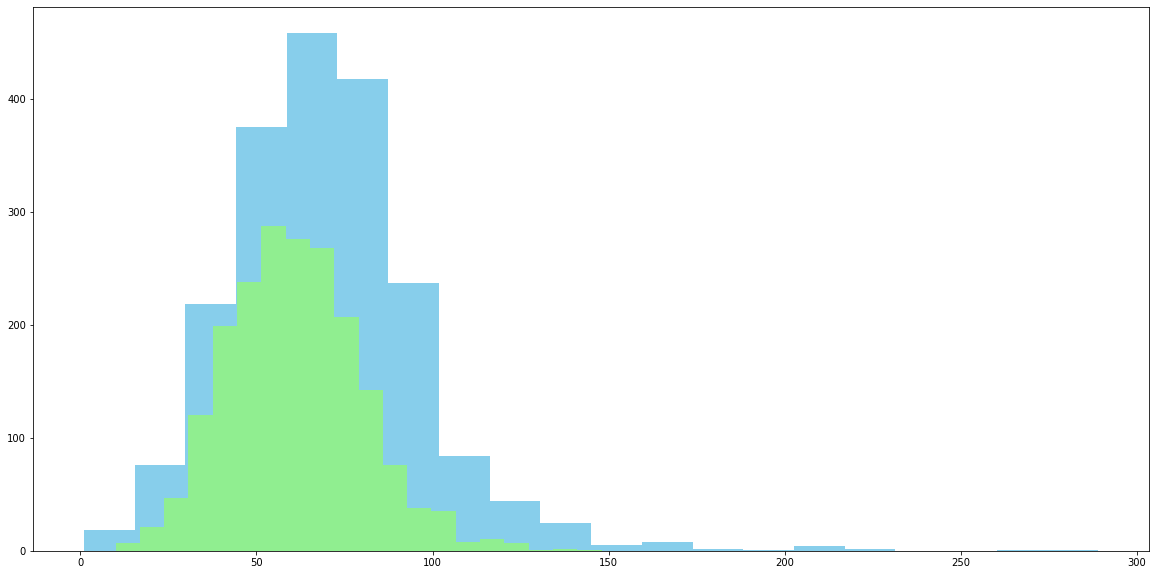

In [19]:
# Explorating Text lenght
train["Text_len"] = train["text"].apply(lambda x: len(x))
plt.figure(figsize=(20,10))
plt.hist(train.loc[train.label=="FAKE",:]["title_len"],bins=20,color = "skyblue")
plt.hist(train.loc[train.label=="REAL",:]["title_len"],bins=20, color = "LightGreen")

In [21]:
(train.loc[train.label=="FAKE",:]["Text_len"]).describe()

count     1976.000000
mean      4110.713057
std       5227.128775
min          1.000000
25%       1337.750000
50%       2616.500000
75%       5094.500000
max      65535.000000
Name: Text_len, dtype: float64

In [24]:
(train.loc[train.label=="REAL",:]["Text_len"]).describe()

count     1990.000000
mean      5294.017085
std       4475.013151
min         43.000000
25%       2706.000000
50%       4694.000000
75%       6825.500000
max      44039.000000
Name: Text_len, dtype: float64

We can detect that fake and Real news have different lengths. Both max lengths differ, fake news usually have a higher length. 

## Preprocessing MODEL 1

In [ ]:
train.head()

,ID,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [ ]:
# Create a series to store the labels: y
y = train["label"]
y.describe()

count     3966
unique       2
top       REAL
freq      1990
Name: label, dtype: object

In [ ]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=53)

In [ ]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
tfidf_vectorizer_TEXT = TfidfVectorizer(stop_words="english", max_df=0.7)
tfidf_vectorizer_TITLE = TfidfVectorizer(stop_words="english", max_df=0.7)

In [ ]:
# Transform the training data: tfidf_train 
tfidf_train_TEXT = tfidf_vectorizer_TEXT.fit_transform(X_train["text"])
tfidf_train_TITLE = tfidf_vectorizer_TITLE.fit_transform(X_train["title"])

In [ ]:
# Transform the test data: tfidf_test 
tfidf_test_TEXT = tfidf_vectorizer_TEXT.transform(X_test["text"])
tfidf_test_TITLE = tfidf_vectorizer_TITLE.transform(X_test["title"])

In [ ]:
# Create the TfidfVectorizer DataFrame: tfidf_df
tfidf_df_TEXT = pd.DataFrame(tfidf_train_TEXT.A, columns=tfidf_vectorizer_TEXT.get_feature_names())
tfidf_df_TITLE = pd.DataFrame(tfidf_train_TITLE.A, columns=tfidf_vectorizer_TITLE.get_feature_names())

In [78]:
#MERGE training data sets
training_ds = pd.concat([tfidf_df_TEXT, tfidf_df_TITLE], axis=1)
training_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3172 entries, 0 to 3171
Columns: 57144 entries, 00 to zulu
dtypes: float64(57144)
memory usage: 1.4 GB


In [ ]:
# Create the TfidfVectorizer DataFrame: tfidf_Xtest
tfidf_Xtest_TEXT = pd.DataFrame(tfidf_test_TEXT.A, columns=tfidf_vectorizer_TEXT.get_feature_names())
tfidf_Xtest_TITLE = pd.DataFrame(tfidf_test_TITLE.A, columns=tfidf_vectorizer_TITLE.get_feature_names())

In [80]:
#MERGE training data sets
testing_ds = pd.concat([tfidf_Xtest_TEXT, tfidf_Xtest_TITLE], axis=1)
testing_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Columns: 57144 entries, 00 to zulu
dtypes: float64(57144)
memory usage: 346.2 MB


## NAIVES BAYES

In [ ]:
# Instantiate a Multinomial Naive Bayes classifier: nb_classifier
nb_classifier = MultinomialNB(alpha=0.1)

In [82]:
# Fit the classifier to the training data
nb_classifier.fit(training_ds, y_train)

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [ ]:
# Create the predicted tags: pred
pred = nb_classifier.predict(testing_ds)

In [84]:
# Calculate the accuracy score: score
score = metrics.accuracy_score(y_test, pred)
print(score)

0.8916876574307305


In [85]:
# Calculate the confusion matrix: cm
cm = metrics.confusion_matrix(y_test, pred, labels=['FAKE','REAL'])
print(cm)

[[354  61]
 [ 25 354]]


## Improving model with alpha


In [ ]:
# Create the list of alphas: alphas
alphas = np.arange(0,1,0.1)

In [ ]:
# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # Fit to the training data
    nb_classifier.fit(training_ds, y_train)
    # Predict the labels: pred
    pred = nb_classifier.predict(testing_ds)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

In [64]:
# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()

Alpha:  0.0


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:507: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Score:  0.8337531486146096

Alpha:  0.1
Score:  0.8916876574307305

Alpha:  0.2
Score:  0.8803526448362721

Alpha:  0.30000000000000004
Score:  0.8702770780856424

Alpha:  0.4
Score:  0.8677581863979849

Alpha:  0.5
Score:  0.8614609571788413

Alpha:  0.6000000000000001
Score:  0.8488664987405542

Alpha:  0.7000000000000001
Score:  0.8425692695214105

Alpha:  0.8
Score:  0.8400503778337531

Alpha:  0.9
Score:  0.8287153652392947



## SVM

In [ ]:
# Instantiate SVM
clf = svm.SVC()

In [ ]:
# Fit the classifier to the training data
svm_classifier = clf.fit(training_ds, y_train)

In [ ]:
# Create the predicted tags: pred
pred1= clf.predict(testing_ds)

In [47]:
# Calculate the accuracy score: score
score1 = metrics.accuracy_score(y_test, pred1)
print(score1)

0.9130982367758187


#Predicting TEST set

In [ ]:
# Transform the test data: tfidf_test 
tfidf_Rtest_TEXT = tfidf_vectorizer_TEXT.transform(test["text"])
tfidf_Rtest_TITLE = tfidf_vectorizer_TITLE.transform(test["title"])

In [ ]:
# Create the TfidfVectorizer DataFrame: tfidf_Xtest
tfidf_Rtest_TEXT = pd.DataFrame(tfidf_Rtest_TEXT.A, columns=tfidf_vectorizer_TEXT.get_feature_names())
tfidf_Rtest_TITLE = pd.DataFrame(tfidf_Rtest_TITLE.A, columns=tfidf_vectorizer_TITLE.get_feature_names())

In [89]:
#MERGE training data sets
Real_TEST_ds = pd.concat([tfidf_Rtest_TEXT, tfidf_Rtest_TITLE], axis=1)
training_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3172 entries, 0 to 3171
Columns: 57144 entries, 00 to zulu
dtypes: float64(57144)
memory usage: 1.4 GB


In [ ]:
#Naives Bayes
NB_real_prediction=nb_classifier.predict(Real_TEST_ds)

In [ ]:
#SVM
SVM_real_prediction = clf.predict(Real_TEST_ds)

In [ ]:
final_submission= test["ID"]

In [ ]:
df_svm_results=pd.DataFrame(SVM_real_prediction)

In [ ]:
df_svm_results.columns = ["prediction"]

In [ ]:
final_submission= pd.concat([final_submission, df_svm_results], axis=1)

In [126]:
final_submission.head()

,ID,prediction
0,10498,FAKE
1,2439,REAL
2,864,REAL
3,4128,REAL
4,662,REAL


In [ ]:
final_submission.to_csv("/content/drive/My Drive/Colab Notebooks/NLP/Benjamin_Chumaceiro_Max_Franco_final_result.csv")

# Conculsions

We can conclude that SVM is the most efficient model for predicting fake news. The highest accuracy score with this model was 0.913. Furthermore, Naive Bayes had a score of 0.81 after tuning the alpha parameters. This is because SVM are more likely to perform better as they can handle non-linearities in the data. Naive Bayes performs best when the features are independent of each other which often does not happen in real.

## ANNEX and Recomendation

In google colab we developed the code below that includes more preprocessing features done with spacy such as Tagging, lemmatization, count of different types of poss-tagging, and others. Due to processing power the computer collapsed many times. For a better score we recommend including this features in the models.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from spacy.lang.en import English
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

nlp = spacy.load('en')

#Import Data
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/NLP/fake_or_real_news_training.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/NLP/fake_or_real_news_test.csv")

#checking columns
train.info()

#checking columns
test.info()

# Cleaning Train set

We checked why we have the 2 extra columns in train set

train[(pd.notnull(train['X1'])) | (pd.notnull(train['X2']))].info()

Since there are only 33 rows which have this issue, we decided to drop them
 

#drop rows with issues
train = train.drop(train[(train["label"] != "REAL") & (train["label"] != "FAKE")].index)
#drop columns X1 & X2
train = train.drop(columns=["X1","X2"])


#Concatenate Datasets in order to do feature engineering
df = pd.concat([train, test])

## Preprocessing

#Finding the lenght of the Titles
df["len_title"] = df["title"].apply(lambda x: len(x))

df[df['label']== "REAL"].describe()

df[df['label']== "FAKE"].describe()

## Lemmatization


Tokenize Text & Titles

df["title_token"] = df['title'].apply(lambda x: nlp(x))
df["text_token"] = df['text'].apply(lambda x: nlp(x))

# BREAK- RUN FROM HERE

#now we lemmatized
df["title_lemma"] = df["title_token"].apply(lambda x: " ".join([t.lemma_ for t in x]))
df["text_lemma"] = df["text_token"].apply(lambda x: " ".join([t.lemma_ for t in x]))

df.head()

We want to get rid of the special char

def del_special_char(x):
  """
  Keeps only alpha, digit & pronouns 

  """
  word_list = list()
  for word in x.split():
    if word.isdigit() or word.isalpha() or word == "-PRON-":
      word_list.append(word)
  return ' '.join(word_list)

#Delete special characters
df["title_lemma_no_spchar"] = df["title_lemma"].apply(lambda x: del_special_char(x))
df["text_lemma_no_spchar"] = df["text_lemma"].apply(lambda x: del_special_char(x))

df.head()

#Create columns with length without special characters
df["title_lemma_no_spchar_len"] = df["title_lemma_no_spchar"].apply(lambda x: len(x.split()))
df["text_lemma_no_spchar_len"] = df["text_lemma_no_spchar"].apply(lambda x: len(x.split()))

df.head()

#NLP in order to postag without special characters -gave up on using this because it crashed becaause of lack of ram
#df['title_nlp_nosp'] = df['text_lemma_no_spchar'].apply(lambda x: nlp(x))
#@df['text_nlp_nosp'] = df['text_lemma_no_spchar'].apply(lambda x: nlp(x))

Tags and Counts

#Postagging - gave up on using this because it crashed becaause of lack of ram
#df["title_post_tag"] = df["title_nlp_nosp"].apply(lambda x: [tag.pos_ for tag in x])
#df["text_posy_tag"] = df["text_nlp_nosp"].apply(lambda x: [tag.pos_ for tag in x])

#Postagging 2.0 
df["title_post_tag"] = df["title_token"].apply(lambda x: [tag.pos_ for tag in x])
df["text_post_tag"] = df["text_token"].apply(lambda x: [tag.pos_ for tag in x])

df.head(3)

#counting postags
df["noun_count_title"] = df["title_post_tag"].apply(lambda x: x.count("NOUN"))
df["adj_count_title"] = df["title_post_tag"].apply(lambda x: x.count("ADJ"))
df["verb_count_title"] = df["title_post_tag"].apply(lambda x: x.count("VERB"))
df["pron_count_title"] = df["title_post_tag"].apply(lambda x: x.count("PROPN"))
df["num_count_title"] = df["title_post_tag"].apply(lambda x: x.count("NUM"))

df["noun_count_text"] = df["text_post_tag"].apply(lambda x: x.count("NOUN"))
df["adj_count_text"] = df["text_post_tag"].apply(lambda x: x.count("ADJ"))
df["verb_count_text"] = df["text_post_tag"].apply(lambda x: x.count("VERB"))
df["pron_count_text"] = df["text_post_tag"].apply(lambda x: x.count("PROPN"))
df["num_count_text"] = df["text_post_tag"].apply(lambda x: x.count("NUM"))

df.head(3)

df.columns

Eliminate Useless columns

df1 = df.drop(columns =['text', 'title', 'title_token',
       'text_token', 'title_lemma', 'text_lemma',
       'title_post_tag', 'text_post_tag'])


df1.head(3)

Separate train & test datasets

df_test = df1[df1["label"].isnull()]
df_train = df1[df1["label"].notnull()]

df_test.head(2)

df_train.head(2)

# Initialize a TfidfVectorizer object: tfidf_vectorizer
title_vec = TfidfVectorizer(stop_words="english", max_df=0.7)

# Create a series to store the labels: y
y = df_train["label"]
#df_train = df_train.drop(columns=["label"])

# Transform the training data: title
tfidf_title_train= title_vec.fit_transform(df_train["title_lemma_no_spchar"])

# Create the TfidfVectorizer DataFrame: tfidf_title_train
df_title_train = pd.DataFrame(data=tfidf_title_train.toarray() , 
                              columns= title_vec.get_feature_names())

# Crashes too big
# Initialize a TfidfVectorizer object:  text
text_vec = TfidfVectorizer(ngram_range=(1,2))

# Crashes too big
# Transform the training data: text
tfidf_text_train= text_vec.fit_transform(df_train["text_lemma_no_spchar"])

# Crashes too big
# Create the TfidfVectorizer DataFrame: tfidf_text_train 
#df_text_train = pd.DataFrame(data=tfidf_text_train.toarray() , 
#                              columns= text_vec.get_feature_names())

